# Acesso ao SD

(esse Notebook roda na máquina local)

Objetivo: rodar instâncias do servidor JupyterLab (JL) no supercomputador Santos Dumont (SD), e desta forma ter acesso aos recursos do SD através do cliente JL rodando no navegador web na máquina local

## Exemplos de configuração do ambiente

* Distribuição Python (Anaconda ou Intel) na máquina local
    * https://www.anaconda.com/products/individual
    * https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/distribution-for-python.html
<br><br>
* Configuração do VPN, SSH, e JupyterLab
    * https://github.com/efurlanm/hpc/blob/master/sd/access_configuring.ipynb
    * https://www.hostinger.com.br/tutoriais/conexao-ssh-sem-senha
    * https://github.com/efurlanm/hpc/blob/master/sd/access_using_jupyterlab.ipynb
<br><br>
* O SSH foi configurado para chave ao invés de senha, tanto na máquina local quanto no SD

* Os arquivos `~/.ssh/config` foram configurados:
    * Na máquina local:

            Host *
                ServerAliveInterval 120
            Host sd
                HostName login.sdumont.lncc.br
                User <NOME_DO_USUARIO>
                ControlMaster auto
                ControlPath ~/.ssh/remote_sd
    * No SD:

            Host *
                ServerAliveInterval 120

## Acessando o Santos Dumont

Primeiro passo: 

* usando o Gerenciador de Rede, fazer a conexão ao VPN:

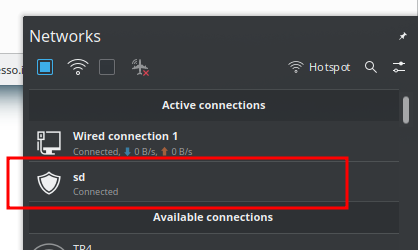

Ao fazer login, uma máquina de login é selecionada aleatoriamente (geralmente sdumont11, sdumont13, ou sdumont14). O comando a seguir abre uma conexão mestre ("SSH Socket") em um dos nós, de tal forma que todos os comandos subsequentes sejam realizados neste mesmo nó. Os comandos são executados no Jupyter Notebook, então basta executar a célula:

In [31]:
! ssh -Nf sd    # não esquecer de ligar o VPN antes

Mostra em qual nó estamos conectados:

In [32]:
! ssh sd 'hostname'

sdumont14


Carrega o módulo anaconda e uma instância do servidor JupyterLab que fica ativo na porta 20210 rodando na máquina de login:

In [33]:
%%bash
ssh -T sd <<'EOF'
BASE=/scratch${PWD#/prj}
module load anaconda3
source $(conda info --base)/etc/profile.d/conda.sh
export PYTHONNOUSERSITE=1  # include pip user packages
conda activate base
conda activate $BASE/env2  # clone of anaconda3 plus mpi4py
jupyter-lab --no-browser --port=20210 --ip=0.0.0.0 > ~/20210.log 2>&1 &
EOF

Faz o encaminhamento de portas do SD para a máquina local onde o acesso é feito usando as portas 8889 e 8890

In [34]:
! ssh -NfTL 8889:localhost:20210 sd

## Montagem do sistema de arquivos remoto

* é independente do Jupyter
* foram criados na máquina local os diretórios `/pr` e `/scratch` com permissões `chmod -R 777` para serem os pontos de montagem:

In [35]:
%%bash
sshfs sd:/prj     /prj     -o workaround=rename,uid=1000,gid=1000
sshfs sd:/scratch /scratch -o workaround=rename,uid=1000,gid=1000

## Link para o cliente JupyterLab rodando na máquina local

* tem que esperar um pouco para o servidor subir (pode demorar minutos)
* se não aparecer nada, ou der erro: mata os processos e tenta de novo

In [38]:
! LNK=$(ssh sd 'cat ~/20210.log | grep "] http://sdumont"'); echo ${LNK/#*'20210'/'http://localhost:8889'}

http://localhost:8889/?token=54aa129752ace50f0454919457691b533472400b816041ec


---

# Sair

* como o `/scratch` do SD é temporário, é importante fazer uma cópia dos arquivos para a máquina local

Desmonta o sistema de arquivos remoto, e encerra o encaminhamento de portas:

In [27]:
! sudo umount -fl /prj /scratch

In [28]:
! pkill -f 8889:

### Encerra a conexão

Uma forma é usar o menu do cliente JupyterLab e selecionar "File > Shut Down" para cada instância do servidor, e em seguida encerrar a conexão mestre, e depois desligar o VPN:

In [29]:
! ssh -O exit sd

Exit request sent.


Outra forma é matar os processos e em seguida encerrar a conexão mestre:

In [23]:
! ssh sd 'pkill -u ${USER} -f jupyter'

In [24]:
! ssh -O exit sd

Control socket connect(/home/x/.ssh/remote_sd): No such file or directory


Desconectar no Gerenciador de Rede

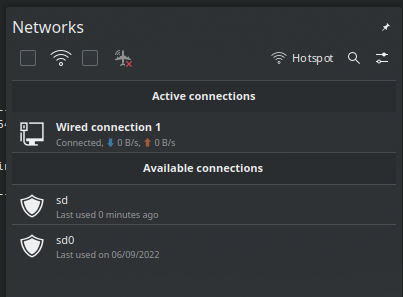

## Mostra processos ativos nos nós de login

In [17]:
ssh sd 'ssh sdumont11 "ps -u ${USER}"; exit'

  PID TTY          TIME CMD
10023 ?        00:00:32 jupyter-lab
10377 ?        00:00:04 python
10380 ?        00:00:03 python
10381 ?        00:00:03 python
10382 ?        00:00:04 python
29037 ?        00:00:00 sshd
29038 ?        00:00:00 ps


In [18]:
ssh sd 'ssh sdumont13 "ps -u ${USER}"; exit'

  PID TTY          TIME CMD
19884 ?        00:00:00 sshd
19885 ?        00:00:00 ps


In [19]:
ssh sd 'ssh sdumont14 "ps -u ${USER}"; exit'

  PID TTY          TIME CMD
 2857 ?        00:00:00 sftp-server
 2882 ?        00:00:00 sftp-server
19512 ?        00:00:00 sshd
24424 ?        00:00:00 python
24427 ?        00:00:00 python
24428 ?        00:00:00 python
28707 ?        00:00:05 jupyter-lab
28800 ?        00:00:00 bash
29112 ?        00:00:00 ssh
29425 ?        00:00:00 sshd
29543 ?        00:00:00 ps
30930 pts/114  00:00:00 bash


In [20]:
ssh sd 'ssh sdumont18 "ps -u ${USER}"; exit'

   PID TTY          TIME CMD
158875 ?        00:00:02 jupyter-lab
159322 ?        00:00:00 sshd
159339 ?        00:00:00 ps


# CONDA - configuração do ambiente

# Referências

* [Running Jupyter Notebooks on Remote Servers](https://towardsdatascience.com/running-jupyter-notebooks-on-reamote-servers-603fbcc256b3?gi=cb964f4376e0)
* [Automatically set up jupyter notebook on remote server ](https://gist.github.com/cdgreenidge/45f2269a0b019d5ac45ab9530d5d75ca)
* [Create ssh tunnel to remote docker container running Jupyter Notebook](https://stackoverflow.com/questions/37576193/create-ssh-tunnel-to-remote-docker-container-running-jupyter-notebook)